# XGBoost: Predicting Win Probability

This notebook demonstrates how to use XGBoost to predict win probability for the home team in college football games.

### What is Gradient Boosting?

Gradient boosting is a machine learning technique used to make predictions. It builds a series of simple models (often decision trees), where each new model tries to fix the mistakes made by the previous ones. By combining these models, gradient boosting creates a strong overall predictor.

### What is XGBoost?

XGBoost stands for "Extreme Gradient Boosting." It is a popular and powerful implementation of gradient boosting. XGBoost is fast, efficient, and often gives very good results for many types of data problems.

## 1. Load and Prepare Data

Just like in the previous notebooks, we will load the training data and define our set of features.

In [1]:
import pandas as pd

df = pd.read_csv("training_data.csv")
features = [
    'home_talent', 'away_talent', 'spread', 'home_elo', 'away_elo',
    'home_adjusted_epa', 'home_adjusted_epa_allowed', 'away_adjusted_epa', 'away_adjusted_epa_allowed',
    'home_adjusted_success', 'home_adjusted_success_allowed', 'away_adjusted_success', 'away_adjusted_success_allowed'
]

df[features].head()

,home_talent,away_talent,spread,home_elo,away_elo,home_adjusted_epa,home_adjusted_epa_allowed,away_adjusted_epa,away_adjusted_epa_allowed,home_adjusted_success,home_adjusted_success_allowed,away_adjusted_success,away_adjusted_success_allowed
0,520.26,842.35,12.0,1346,1695,0.149963,0.194471,0.212555,0.201952,0.416381,0.423596,0.472503,0.444595
1,619.03,798.44,8.5,1415,1729,0.131300,0.178276,0.180898,0.034531,0.406290,0.449150,0.420687,0.345722
2,872.00,813.92,2.5,1632,1792,0.138527,0.140860,0.142758,0.154331,0.420952,0.418720,0.457329,0.438618
3,982.66,652.07,-32.5,2125,1419,0.223040,0.048181,0.188880,0.216253,0.455164,0.333377,0.446300,0.482203
4,654.64,505.29,-5.5,1697,1664,0.157222,0.124830,0.189072,0.065593,0.469674,0.425908,0.474362,0.363824


We will be predicting home team win probability. As such, we will define our target variable as a binary outcome: 1 if the home team wins, 0 otherwise.

In [2]:
df['home_win'] = (df['home_points'] > df['away_points']).astype(int)
df['home_win'].value_counts()

home_win
1    2573
0    1947
Name: count, dtype: int64

## 2. Train/Test Split

As in the previous notebook, we will split our data into training and testing sets using `train_test_split`. This time, we will use the `stratify` parameter to ensure that the distribution of the target variable is preserved in both sets.

In [3]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df['home_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77, stratify=y)

## 3. Train XGBoost Classifier

### What is XGBoost Classifier?

The XGBoost Classifier is a tool in XGBoost used for classification problems. Classification means sorting things into categories, like predicting if a team will win or lose (win = 1, lose = 0). The classifier learns from data to make these predictions.

### What is the `eval_metric` Parameter?

The `eval_metric` parameter tells XGBoost how to measure its performance while training. For example, `'logloss'` is a common metric for classification. It measures how well the predicted probabilities match the actual outcomes. Choosing the right metric helps the model learn better.

### What is the `predict_proba` Function?

The `predict_proba` function gives the probability that each example belongs to each class. For example, it might say there is a 90% chance the home team will win. This is useful when you want to know not just the prediction (win/lose), but also how confident the model is.

### Why Use a Classifier and Not a Regressor?

We use a classifier because our target is a category: win (1) or lose (0). A regressor is used for predicting numbers, like scores. Since we want to predict which team will win (a yes/no question), a classifier is the right choice.

In [4]:
import xgboost as xgb

model = xgb.XGBClassifier(eval_metric='logloss', random_state=77)
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.5).astype(int)

## 4. Evaluate Model Performance

In regression problems, we predict a number (like the score), so we use metrics like Mean Squared Error (MSE) or Mean Absolute Error (MAE) to measure how close our predictions are to the actual values.

In classification problems, we predict categories (like win or lose), so we need different metrics that make sense for this type of prediction. Accuracy, log loss, and AUC are designed to measure how well the model sorts things into the right categories and how confident it is in those predictions.

**Accuracy:**  
Accuracy tells you what percentage of games the model predicted correctly. If the model says the home team will win and they do, that’s correct. If it says they’ll lose and they do, that’s also correct. Higher accuracy means more correct predictions.

**Log Loss:**  
Log loss measures how close the model’s predicted probabilities are to the actual outcomes. If the model is very confident but wrong (predicts a 99% chance of winning, but the team loses), log loss is high. Lower log loss means the model’s confidence matches reality better.

**AUC (Area Under the Curve):**  
AUC shows how well the model separates winners from losers. It looks at all possible thresholds for deciding win or lose and measures how often the model ranks a real winner higher than a real loser. An AUC of 1.0 is perfect; 0.5 means the model is guessing.

**In football game predictions:**  
- **High accuracy** means you’re often right about who wins.
- **Low log loss** means your win probabilities are realistic and not overconfident.
- **High AUC** means your model is good at telling apart games the home team will win from those they’ll lose.

In [5]:
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Log Loss: {:.3f}".format(log_loss(y_test, y_proba)))
print("AUC: {:.3f}".format(roc_auc_score(y_test, y_proba)))

Accuracy: 0.710
Log Loss: 0.626
AUC: 0.780


## 5. Calibration Curve

The calibration curve is a graphical representation that helps us understand how well the predicted probabilities from a model align with the actual outcomes. In simpler terms, it shows us if the model is good at estimating the chances of an event happening.

Here's how to interpret the calibration curve:

1. **Perfect Calibration Line:** The diagonal line from (0,0) to (1,1) represents perfect calibration. If a model predicts a 70% chance of winning, then ideally, that team should win 70% of the time. If the points on the curve closely follow this line, it means the model's predictions are well-calibrated.

2. **Above the Line:** If the curve is above the diagonal line, it indicates that the model is underestimating the probabilities. For example, if the model predicts a 60% chance of winning, but the team actually wins 80% of the time, this would be reflected in the curve being above the line.

3. **Below the Line:** Conversely, if the curve is below the diagonal line, the model is overestimating the probabilities. For instance, if the model predicts a 90% chance of winning, but the team only wins 70% of the time, this would show up as points below the line.

By analyzing the calibration curve, we can assess the model's confidence in its predictions. A well-calibrated model not only makes accurate predictions but also provides reliable probability estimates. This is especially important in scenarios like sports betting, where understanding the likelihood of an outcome can significantly impact decision-making.

In summary, the calibration curve is a valuable tool for evaluating how well a model's predicted probabilities match actual outcomes, helping us gauge the model's confidence and reliability.

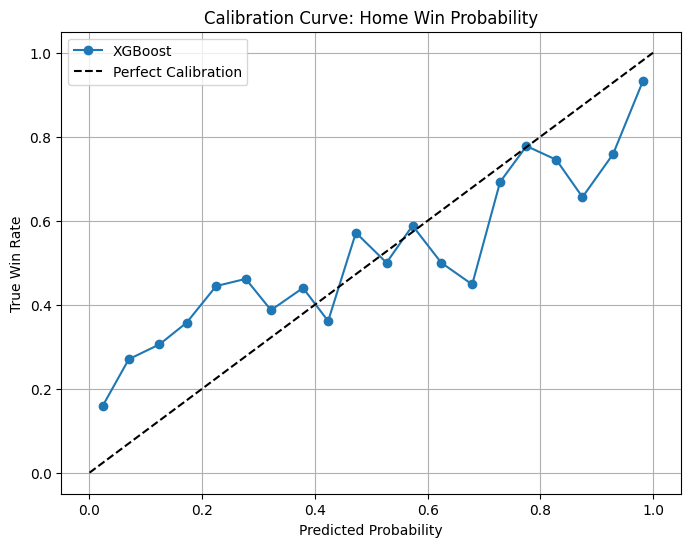

In [6]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=20)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Win Rate')
plt.title('Calibration Curve: Home Win Probability')
plt.legend()
plt.grid(True)
plt.show()

## 6. Analyze Feature Importance

The plot shows the importance of each feature in the model based on the "gain" metric. Gain measures the improvement in accuracy brought by a feature to the branches it is on. In simpler terms, it tells us how much a feature contributes to making better predictions.

From the plot, we can see which features are the most influential in predicting the outcome. Features with higher gain values are more important for the model's decisions. This information can help us understand the key factors that affect the game's outcome and guide us in feature engineering efforts, such as creating new features or modifying existing ones to improve model performance.

As you can see below, the Vegas spread was by far the most important feature in predicting the home team's win probability.

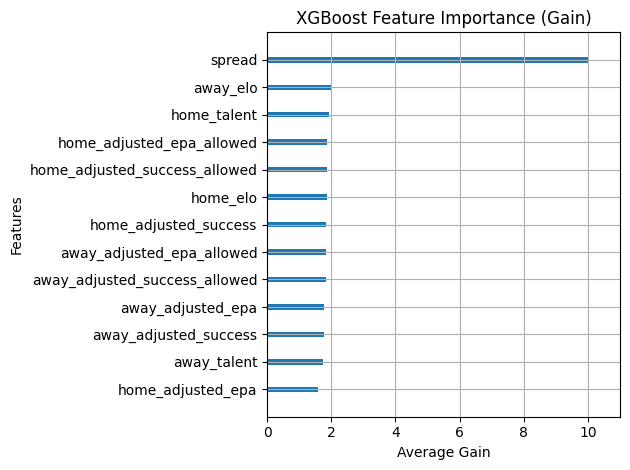

In [7]:
import matplotlib.pyplot as plt

xgb_plot = xgb.plot_importance(model, importance_type='gain', show_values=False, xlabel='Average Gain', ylabel='Features', title='XGBoost Feature Importance (Gain)', grid=True)
plt.tight_layout()
plt.show()

## 7. Save Model

Save the model to a file for later use. This allows us to reuse the trained model without needing to retrain it every time we want to make predictions.

In [8]:
import joblib

joblib.dump(model, "xgb_home_win_model.pkl")

['xgb_home_win_model.pkl']

## 8. Load Model
Load the saved model and create a new DataFrame with the same features as the training data. The model will then give you the probability that the home team will win, as a number between 0 and 1.

In [17]:
modl = joblib.load("xgb_home_win_model.pkl")

pdf = df.query("season == 2023 and week == 13")

pdf['prediction'] = model.predict_proba(pdf[features])[:, 1].squeeze().clip(0, 1)

pdf[['home_team', 'away_team', 'spread', 'prediction']].head(10)

/tmp/ipykernel_75188/813688740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['prediction'] = model.predict_proba(pdf[features])[:, 1].squeeze().clip(0, 1)


,home_team,away_team,spread,prediction
3798,Stanford,Notre Dame,26.0,0.020595
3799,Georgia Tech,Georgia,25.0,0.003897
3800,Louisville,Kentucky,-7.5,0.313604
3801,Tennessee,Vanderbilt,-27.0,0.992003
3802,Kansas State,Iowa State,-9.5,0.095773
3803,Texas,Texas Tech,-16.0,0.995435
3804,Cincinnati,Kansas,7.5,0.049573
3805,Oklahoma,TCU,-10.0,0.914049
3806,Baylor,West Virginia,13.0,0.088655
3807,Ball State,Miami (OH),4.0,0.205628


## 9. Next Steps

- **Hyperparameter Tuning:** Adjust the settings of the XGBoost model to find the best combination for our data. This can improve the model's performance by making it more accurate. Some important parameters to try tuning are:
    - **n_estimators:** The number of trees the model builds. More trees can help, but too many can lead to overfitting.
    - **max_depth:** How deep each tree can grow. Deeper trees can learn more complex patterns, but may also overfit.
    - **learning_rate:** Controls how much each tree changes the model. Lower values make learning slower but can improve accuracy.
    - **subsample:** The fraction of the training data used for each tree. Using less data can help prevent overfitting.
    - **colsample_bytree:** The fraction of features used for each tree. This can also help prevent overfitting.
    - **gamma:** Makes the model more conservative by requiring a minimum improvement to split a node.
    - **min_child_weight:** The minimum number of samples needed in a leaf node. Higher values can make the model simpler.
- **Feature Engineering:** Experiment with the features included in the training data. Add new features from the data and try different combinations to see if they improve the model's performance.
- **Cross-Validation:** Use cross-validation to assess the model's performance more robustly. This involves splitting the data into multiple parts, training the model on some parts and testing it on others, to ensure it generalizes well to new data.